#Unadjusted Analyses#

Running one way ANOVA tests (for nominal data) and unadjusted linear regression (for continuous data) with excess vascular age.

##Table of Contents##

**1. ANOVA: Nominal variables to be tested**
- Race
- Education
- Income
- History of CVD
- Discrimination score classification

**2. Linear regression: Continuous variables to be tested**
- C-Reactive Protein
- BMI

**3. Racial group viz**
- Education breakdown
- Income breakdown
- History of CVD breakdown
- Discrimination breakdown
- BMI breakdown

In [26]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import scipy as sp
from scipy import stats
import scipy.stats.mstats as mst
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

data = pd.read_csv('901_CleanedData.csv', low_memory=False)

Modifying the independent variable (perceived discrimination score) to make it a nominal variable.

If the average discrimination score is less than two (less than a 'Once' on Likert scale) then 0, otherwise 1. In this example, 0 represents low discrimination and 1 represents high discrimination.

In [27]:
def newIV(row):
    if row['DISC_SCORE0'] < 2:
        val = 0
    else:
        val = 1
    return val

data['DISC'] = data.apply(newIV, axis=1)

##ANOVA##

In [28]:
def onewayANOVA(var, var_list):
    formula = 'LV_AGE_DIFF0 ~ C(' + var + ')'
    var_lm = smf.ols(formula, data).fit()
    var_tk = pairwise_tukeyhsd(data['LV_AGE_DIFF0'], data[var])
    var_anova = anova_lm(var_lm)
    
    var_ms = var_anova.mean_sq[1]
    
    results = []
    
    for x in var_list:
        var_mean = data[data[var] == x].groupby(var).LV_AGE_DIFF0.mean()[0]
        var_count = data[data[var] == x][var].count()
        se = np.sqrt(var_ms/var_count)
        tcrit = stats.t.ppf(1-0.025, var_count - 1)
        lower = var_mean - tcrit * se
        upper = var_mean + tcrit * se
        results.append([x, var_count, var_mean, se, lower, upper])

    print var_anova.F[0]
    print var_anova['PR(>F)'][0]
    print ""
    
    print var_anova
    
    for x in results:
        print x
    
    print ""
    
    print var_tk
    
    return;

###Race###

In [29]:
race = 'RACE'
race_list = ['Caucasian', 'Black', 'Asian', 'Hispanic']
onewayANOVA(race, race_list)

110.94183462
2.1336232527e-68

            df         sum_sq       mean_sq           F        PR(>F)
C(RACE)      3   62267.804473  20755.934824  110.941835  2.133623e-68
Residual  3258  609534.139120    187.088440         NaN           NaN
['Caucasian', 1529, -2.147155003270111, 0.3497999432835745, -2.8332937931605948, -1.4610162133796272]
['Black', 922, 5.9316702819956619, 0.45046185083489021, 5.0476194977831748, 6.8157210662081491]
['Asian', 529, -5.6105860113421553, 0.59469685450189413, -6.7788483951829912, -4.4423236275013194]
['Hispanic', 282, 4.6950354609929077, 0.81451469362968598, 3.0917104536352329, 6.2983604683505821]

 Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff  lower   upper  reject
---------------------------------------------------
  Asian     Black   11.5423   9.6247 13.4599  True 
  Asian   Caucasian  3.4634    1.69   5.2368  True 
  Asian    Hispanic 10.3056   7.7134 12.8979  True 
  Black   Caucasian -8.0788  -9.5448 -6.6129  True

###Education###

In [30]:
data.DEGREE.value_counts(dropna=False)

3    1069
5     735
4     651
2     572
1     235
Name: DEGREE, dtype: int64

In [31]:
def stringy_degree(row):
    if row['DEGREE'] == 1:
        val = '1'
    elif row['DEGREE'] == 2:
        val = '2'
    elif row['DEGREE'] == 3:
        val = '3'
    elif row['DEGREE'] == 4:
        val = '4'
    else:
        val = '5'
    return val

data['ST_DGREE'] = data.apply(stringy_degree, axis=1)

In [32]:
edu = 'ST_DGREE'
edu_list = ['1', '2', '3', '4', '5']

onewayANOVA(edu, edu_list)

39.5843281698
2.0452652722e-32

               df         sum_sq      mean_sq          F        PR(>F)
C(ST_DGREE)     4   31145.185574  7786.296393  39.584328  2.045265e-32
Residual     3257  640656.758019   196.701492        NaN           NaN
['1', 235, 4.5361702127659571, 0.914892137724448, 2.7336921350213315, 6.3386482905105828]
['2', 572, 3.4458041958041958, 0.58641600123784476, 2.2940085504221046, 4.5975998411862875]
['3', 1069, 1.9859681945743686, 0.42895819971459653, 1.1442716960397141, 2.827664693109023]
['4', 651, -3.2672811059907834, 0.54968429923090534, -4.3466523668495975, -2.1879098451319692]
['5', 735, -3.3891156462585035, 0.51732105790864302, -4.4047209715926137, -2.3735103209243933]

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
  1      2    -1.0904  -4.0563   1.8755 False 
  1      3    -2.5502   -5.308   0.2076 False 
  1      4    -7.8035  -10.7165 -4.8904  True 
  1 

###Income###

In [33]:
data.INCOME0.value_counts(dropna=False)

3    1240
2    1077
1     483
4     462
Name: INCOME0, dtype: int64

In [34]:
def stringy_income(row):
    if row['INCOME0'] == 1:
        val = '1'
    elif row['INCOME0'] == 2:
        val = '2'
    elif row['INCOME0'] == 3:
        val = '3'
    else:
        val = '4'
    return val

data['ST_INC'] = data.apply(stringy_income, axis=1)

In [35]:
inc = 'ST_INC'
inc_list = ['1', '2', '3', '4']

onewayANOVA(inc, inc_list)

52.2788142891
5.37063239021e-33

             df         sum_sq       mean_sq          F        PR(>F)
C(ST_INC)     3   30854.487150  10284.829050  52.278814  5.370632e-33
Residual   3258  640947.456443    196.730343        NaN           NaN
['1', 483, 6.3913043478260869, 0.63820780165243851, 5.1372911907767751, 7.6453175048753987]
['2', 1077, 0.82636954503249771, 0.42739341107959433, -0.012249470543251539, 1.6649885606082471]
['3', 1240, -1.1370967741935485, 0.39831332159402461, -1.9185399089535622, -0.3556536394335349]
['4', 462, -4.383116883116883, 0.65255134092933742, -5.6654606729880852, -3.1007730932456807]

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
  1      2    -5.5649  -7.5392  -3.5907  True 
  1      3    -7.5284  -9.4621  -5.5947  True 
  1      4    -10.7744 -13.1205 -8.4283  True 
  2      3    -1.9635  -3.4651  -0.4618  True 
  2      4    -5.2095  -7.2145  -3.2045  Tru

###History of CVD###

In [36]:
data.CVD.value_counts(dropna=False)

0    3171
1      91
Name: CVD, dtype: int64

In [37]:
def stringy_cvd(row):
    if row['CVD'] == 1:
        val = '1'
    else:
        val = '0'
    return val

data['ST_CVD'] = data.apply(stringy_cvd, axis=1)

In [38]:
cvd = 'ST_CVD'
cvd_list = ['0', '1']

onewayANOVA(cvd, cvd_list)

72.8687662344
2.09253070027e-17

             df         sum_sq       mean_sq          F        PR(>F)
C(ST_CVD)     1   14688.060712  14688.060712  72.868766  2.092531e-17
Residual   3260  657113.882881    201.568676        NaN           NaN
['0', 3171, -0.19331441185745821, 0.25212354230321321, -0.68765622205269705, 0.30102739833778069]
['1', 91, 12.692307692307692, 1.4883011767250354, 9.7355376357950885, 15.649077748820295]

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower   upper  reject
--------------------------------------------
  0      1    12.8856  9.9259 15.8453  True 
--------------------------------------------


###Discrimination Classification###

In [39]:
data.DISC.value_counts(dropna=False)

0    2226
1    1036
Name: DISC, dtype: int64

In [40]:
def stringy_disc(row):
    if row['DISC'] == 1:
        val = '1'
    else:
        val = '0'
    return val

data['ST_DISC'] = data.apply(stringy_disc, axis=1)

In [41]:
disc = 'ST_DISC'
disc_list = ['0', '1']

onewayANOVA(disc, disc_list)

28.5577752353
9.71953739998e-08

              df         sum_sq      mean_sq          F        PR(>F)
C(ST_DISC)     1    5833.915722  5833.915722  28.557775  9.719537e-08
Residual    3260  665968.027871   204.284671        NaN           NaN
['0', 2226, -0.74618149146451029, 0.30293908538622299, -1.3402543515324457, -0.15210863139657493]
['1', 1036, 2.1264478764478763, 0.44405627570205325, 1.2550945989608682, 2.9978011539348843]

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  0      1     2.8726  1.8187 3.9266  True 
-------------------------------------------


##Linear Regression##

###BMI###

In [42]:
bmi_lm = smf.ols('LV_AGE_DIFF0 ~ BMI0', data).fit()
bmi_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           LV_AGE_DIFF0   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     696.2
Date:                Thu, 10 Dec 2015   Prob (F-statistic):          3.14e-139
Time:                        20:16:21   Log-Likelihood:                -13002.
No. Observations:                3262   AIC:                         2.601e+04
Df Residuals:                    3260   BIC:                         2.602e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -23.5598      0.928    -25.397      0.000       -25.379   -21.741
BMI0           0.8397      0.032     26.386      0.000         0.777     0.902
==============================================================================
Omnibus:                     1287.723   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7171.370
Skew:                           1.797   Prob(JB):                         0.00
Kurtosis:                       9.313   Cond. No.                         119.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

###CRP###

In [43]:
crp_lm = smf.ols('LV_AGE_DIFF0 ~ CRPRESU0', data).fit()
crp_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           LV_AGE_DIFF0   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     246.5
Date:                Thu, 10 Dec 2015   Prob (F-statistic):           1.31e-53
Time:                        20:16:21   Log-Likelihood:                -13199.
No. Observations:                3262   AIC:                         2.640e+04
Df Residuals:                    3260   BIC:                         2.641e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -2.2120      0.286     -7.740      0.000        -2.772    -1.652
CRPRESU0       0.6112      0.039     15.701      0.000         0.535     0.688
==============================================================================
Omnibus:                     1266.296   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7437.785
Skew:                           1.741   Prob(JB):                         0.00
Kurtosis:                       9.526   Cond. No.                         8.70
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
data.to_csv('900_CleanedData.csv', index = False)

##Visualization##


- Education breakdown
- Income breakdown
- History of CVD breakdown
- Discrimination breakdown
- BMI breakdown

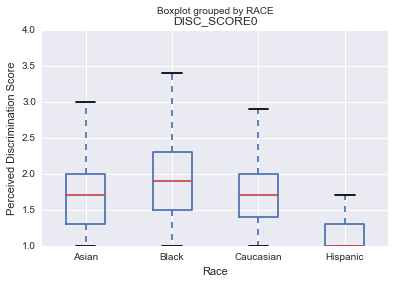

In [46]:
data.boxplot(column="DISC_SCORE0", by = "RACE")
plt.xlabel('Race')
plt.ylabel('Perceived Discrimination Score')